# Anylsis Pipeline for the project
Team Dog: Maximilian Bernhardt, Patrick Ebner, Simon Enkel, Claudius Hilser, Enno Schwenk

**Content of this notebook:** 
1. Imports
2. Data read-in
3. Defining variables, dataframes and lists
4. Defining functions
5. Data preprocessing & Counting fixations
6. Data Visualization
7. Sanity Checks

### Imports

In [136]:
#Import packages
import numpy as np
import pandas as pd
import os, re
from collections import Counter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("white")

### Data read-in
For now, all the filenames get saved in a list. The whole files will be read in with a loop down below.

In [137]:
# Define path for folder with participant data
folder_path = '../data/raw'

# Save all filenames in a list
tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.tsv')]


### Defining variables, dataframes and lists

In [138]:
# Define target coordinates
target_coords = [
    (-320, 0), (320, 0), (-277, -160), (277, 160), 
    (0, 320), (0, -320), (277, -160), (-277, 160), 
    (-160, -277), (160, 277), (160, -277), (-160, 277)
]
# Define target names according to the coordinates
target_names = [
    'nine', 'three', 'eight', 'two', 
    'twelve', 'six', 'four', 'ten', 
    'seven', 'one', 'five', 'eleven'
]
target_coord_to_name = dict(zip(target_coords, target_names))

# Ensure the dataframe is in the correct order from one to twelve
target_order = [
    'one', 'two', 'three', 'four', 
    'five', 'six', 'seven', 'eight', 
    'nine', 'ten', 'eleven', 'twelve'
]

# Save screen-dimensions and threshold to define whether a target was fixated or not
screen_width = 1920
screen_height = 1080
threshold = 100

# Initialize an empty dataframe for the sums of fixations
sum_df = pd.DataFrame(columns=['Coordinate', 'Count'])

# Define pairs for stimuli belonging together
pairs = [('seven', 'one'), ('eight', 'two'), ('nine', 'three'), ('ten', 'four'), ('eleven', 'five'), ('twelve', 'six')]

# Count all fixations for each participant
fixation_count = []

### Defining Functions
All functions used for the visualizing the results of the research are defined in the following blocks. 

**find_closest_target(row, target_coords, threshold)** \
The first function finds the stimuli which the the fixation lands on. 

**import_coordinates(input_coordinates)** \
This function is used to convert the coordinates logged in OpenSesame in a string into a list which can be used afterwards to calculate whether the fixation was near one of the two stimuli shown. 

**check_balancing_errors(df)** \
In this function, all values for the USER-column of the participant data gets counted to gain an overview about all the logged values. This can prove whether each dataset contains all necessary logs to execute the following code for calculating the first fixations.




In [139]:
# Function to find the closest target coordinate within the threshold distance
def find_closest_target(row, target_coords, threshold):
    x, y = row['x_coord'], row['y_coord']
    for tx, ty in target_coords:
        if np.sqrt((x - tx)**2 + (y - ty)**2) <= threshold:
            return (tx, ty)
    return None

# Function to convert the coordinates from a string into a list with numbers
def import_coordinates(input_coordinates):
    pattern = r"-?\d+"
    coordinates_list = []

    # Iterate over all lines of the input
    for i in range(0, len(input_coordinates)):
        # Using regex to find all numbers in the string
        numbers = re.findall(pattern, input_coordinates[i])

        # Convert the extracted number strings to integers
        coordinates = [int(num) for num in numbers]
        coordinates_list.append(coordinates)

    return coordinates_list

# Function to print out all the coutns of the logs of the current participant
def check_balancing_errors(df):
    # Count the occurrences of each unique value in the 'USER' column
    event_counts = df['USER'].value_counts()
    print("Event frequency in the 'USER' column:")
    print(event_counts)
    print()  # Add a blank line for better readability


### Data Preprocessing & Counting fixations
In the data preprocessing, the data gets prepared for the analysis following in this script. 
At first, the files are read by iterating over the filenames saved above. Afterwards, unnecessary columns get dropped, the time gets normalized to start at 0 and the fixations are extracted. Furthermore, the valid fixations are anaylzed for their positions and are added accordingly to the position-number where the participant focussed. \
Finally, the dataframe *sum_df* contains a list with the total number of fixations for every stimuli position (from one to twelve). 

In [140]:
# Initialize an empty dataframe for the sums of fixations
sum_df = pd.DataFrame(columns=['Coordinate', 'Count'])
df_first_fixations = pd.DataFrame()

# Iterate through all .tsv-Files and sum up the fixations for the current file in sum_df
for file in tsv_files:
    # Load the file
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep='\t')

    # Drop unnecessary columns
    df = df[['CNT', 'TIME', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD', 'FPOGID', 'FPOGV', 'BPOGX', 'BPOGY', 'BPOGV', 'USER']]

    # Normalize the time for the current file to begin at zero
    df['TIME'] = df['TIME'] - df['TIME'].iloc[0]

    # Filter for valid points
    df = df[(df['FPOGV'] == 1) | (df['USER'] == 'SHOW_STIMULUS') | (df['USER'].str.contains('COORDINATES'))]

    # Create a new dataframe to save all fixations
    df_fixations = df.groupby('FPOGID').agg({
        'FPOGX': 'last',
        'FPOGY': 'last',
        'TIME': 'last',
        #'USER': 'first'  # Or another method to handle multiple users
    }).reset_index()

    df_fixations['x_coord'] = (df_fixations['FPOGX'] - 0.5) * screen_width
    df_fixations['y_coord'] = (df_fixations['FPOGY'] - 0.5) * screen_height

    # Find the indices of 'SHOW_STIMULUS' events
    show_stimulus_times = df[df['USER'] == 'SHOW_STIMULUS']['TIME'].values

    # Get the coordinates for the current stimuli shown
    df_coordinates_str = df[(df['USER'].str.contains('COORDINATES')) & (df['USER'].notna())]
    df_coordinates_str = df_coordinates_str[['USER', 'TIME']]
    coordinates_list = df_coordinates_str['USER'].to_list()

    coordinates_list = import_coordinates(coordinates_list)

    restructured_list = []
    for item in coordinates_list:
        restructured_list.append((item[0], item[1]))
        restructured_list.append((item[2], item[3]))

    # Initialize a list to store the target coordinates of first fixations
    first_fixation_targets = []

    i = 0

    # Iterate over each 'SHOW_STIMULUS' event time
    for show_time in show_stimulus_times:
        
        # Filter fixations that occur after the 'SHOW_STIMULUS' event time
        valid_fixations = df_fixations[df_fixations['TIME'] > show_time]

        target_list = []
        target_list.append(restructured_list[i])
        target_list.append(restructured_list[i+1])
        
        # Find the first fixation within the threshold distance
        for idx, row in valid_fixations.iterrows():
            #target = find_closest_target(row, target_coords, threshold)
            target = find_closest_target(row, target_list, threshold)
            if target:
                first_fixation_targets.append(target)
                break        
        i = i + 2
    
    # Map the target coordinates to their descriptive names
    first_fixation_targets_named = [target_coord_to_name[target] for target in first_fixation_targets]

    # Count the occurrences of each target coordinate name
    target_counts = Counter(first_fixation_targets_named)

    # Convert the counts to a DataFrame for visualization
    target_counts_df = pd.DataFrame(list(target_counts.items()), columns=['Coordinate', 'Count'])

    
    target_counts_df['Coordinate'] = pd.Categorical(target_counts_df['Coordinate'], categories=target_order, ordered=True)
    target_counts_df = target_counts_df.sort_values('Coordinate')

    # Add number of fixations to the dataframe sum_df which consists of all fixations
    if sum_df.empty:
        sum_df = target_counts_df.copy()
        fixation_count = []
    else:
        sum_df = sum_df.set_index('Coordinate').add(target_counts_df.set_index('Coordinate'), fill_value=0).reset_index()
        
    fixation_count.append(sum(target_counts_df['Count']))
   

### Data Visualization
In the following parts, the data gets visualized using different types of plots. Target of these plots is to deal with the topic: "Does diagonal positioning of stimuli eliminate the left-bias in viewing images?​" 


**Count of first fixations** \
The first plot shows, which stimuli position was fixated how often from all participants.

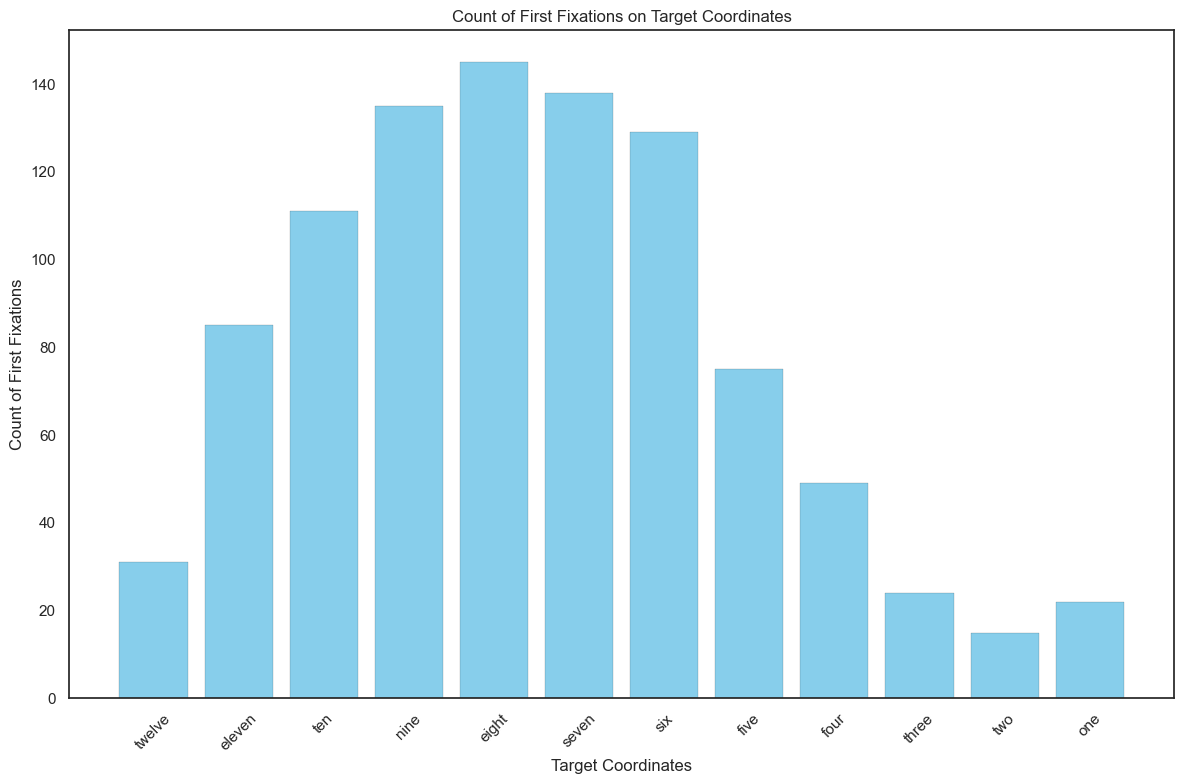

In [141]:
plt.figure(figsize=(12, 8))
reversed_coordinates = sum_df['Coordinate'][::-1]
reversed_count = sum_df['Count'][::-1]
plt.bar(reversed_coordinates, reversed_count, color='skyblue', edgecolor='black', linewidth = 0.1)
plt.xlabel('Target Coordinates')
plt.ylabel('Count of First Fixations')
plt.title('Count of First Fixations on Target Coordinates')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

**Clock-wise layout of results** \
In the second visual, the amount of fixations for each position are visualized clock-wise to get a better overview about whether there is a tendency to the left or to the right.

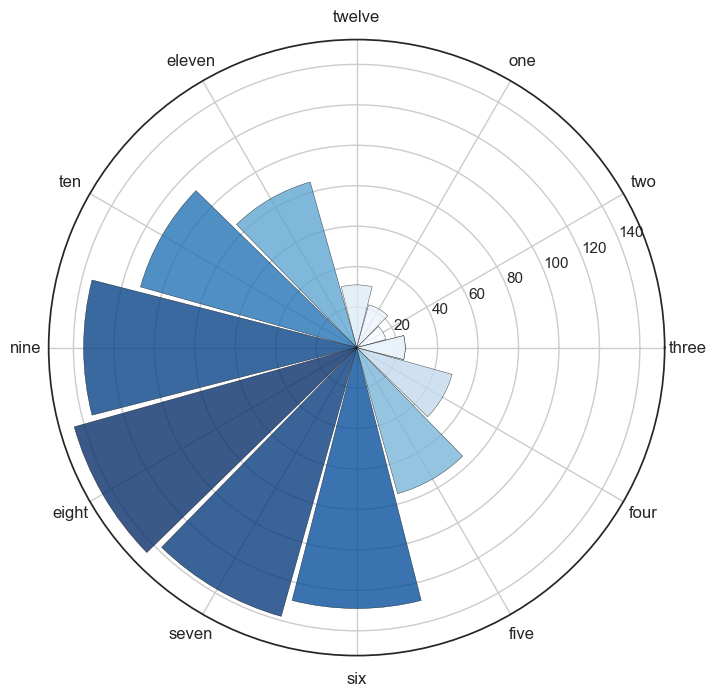

In [142]:
# Die Kategorien in der gewünschten Reihenfolge umsortieren
categories = ['three', 'two', 'one','twelve', 'eleven', 'ten', 'nine', 'eight', 'seven', 'six', 'five', 'four']

# Die Werte in der Reihenfolge der Kategorien anordnen
values = sum_df.set_index('Coordinate').reindex(categories)['Count'].fillna(0).values

# Anzahl der Kategorien
num_vars = len(categories)

# Winkel für jedes Segment berechnen
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Werte für den geschlossenen Radialplot erweitern
values = np.concatenate((values,[values[0]]))
angles += angles[:1]

# Colormap definieren (eine Farbe mit unterschiedlichen Intensitäten)
cmap = plt.cm.Blues  # Blau als Basisfarbe
norm = Normalize(vmin=min(values), vmax=max(values))
colors = cmap(norm(values))

# Plot erstellen
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Balken für jedes Segment erstellen
bars = ax.bar(angles, values, width=0.5, color=colors, edgecolor='black', linewidth=0.3, alpha=0.8)

# Kategorien als Beschriftungen setzen
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, ha='center')

plt.show()

**Percentual comparison for the different stimuli pairs** \
To gain another insight to the left-/right-distribution, the ratio for each stimuli pair is calculated and shown in bars from 0 to 100 percent. 

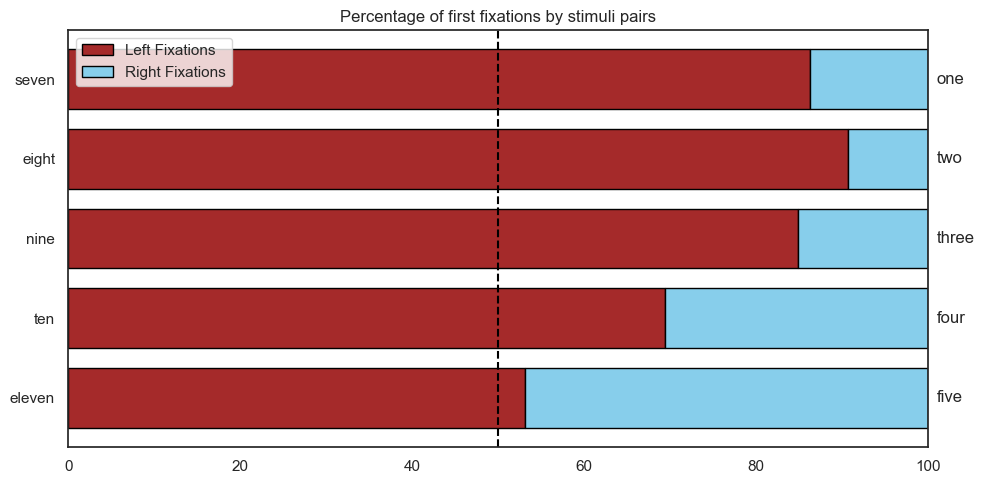

In [143]:
pairs = [('seven', 'one'), ('eight', 'two'), ('nine', 'three'), ('ten', 'four'), ('eleven', 'five')]

# Calculte the sum for each pair
pair_sums = []
for coord1, coord2 in pairs:
    count1 = sum_df[sum_df['Coordinate'] == coord1]['Count'].values[0]
    count2 = sum_df[sum_df['Coordinate'] == coord2]['Count'].values[0]
    total = count1 + count2
    pair_sums.append((coord1, coord2, count1 / total, count2 / total))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Reverse the order of the pairs
pair_sums = pair_sums[::-1]

# Prepare values for the diagram
left_description = [f'{pairs[4-i][0]}' for i in range(0, len(pair_sums))]
right_description = [f'{pairs[4-i][1]}' for i in range(0, len(pair_sums))]
left_fixations = [left for _, _, left, _ in pair_sums]
right_fixations = [right for _, _, _, right in pair_sums]

# Upgrade values to percent
left_fixations = [i * 100 for i in left_fixations]
right_fixations = [i * 100 for i in right_fixations]


# Create plot
bar_width = 0.75
y = np.arange(len(left_description))

# Create left and right bars
ax.barh(y, left_fixations, color='brown', height=bar_width, edgecolor='black', label='Left Fixations')
ax.barh(y, right_fixations, left=left_fixations, color='skyblue', height=bar_width, edgecolor='black', label='Right Fixations')

# Add center line
ax.axvline(50, color='black', linestyle='--')

# Define labels and titel
ax.set_yticks(y)
ax.set_yticklabels(left_description)
#ax.set_xlabel('Percentage of first fixations to the left | right')
ax.set_title('Percentage of first fixations by stimuli pairs')
ax.legend()

# Add right side labels
for i in range(len(y)):
    ax.text(101, y[i], right_description[i], va='center')

# Adjust x-axis from 0 to 100
ax.set_xlim(0, 100)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

**Pairwise comparison of stimuli pairs** \
Finally, there is another comparison of the stimuli pairs dealing with total numbers this time.

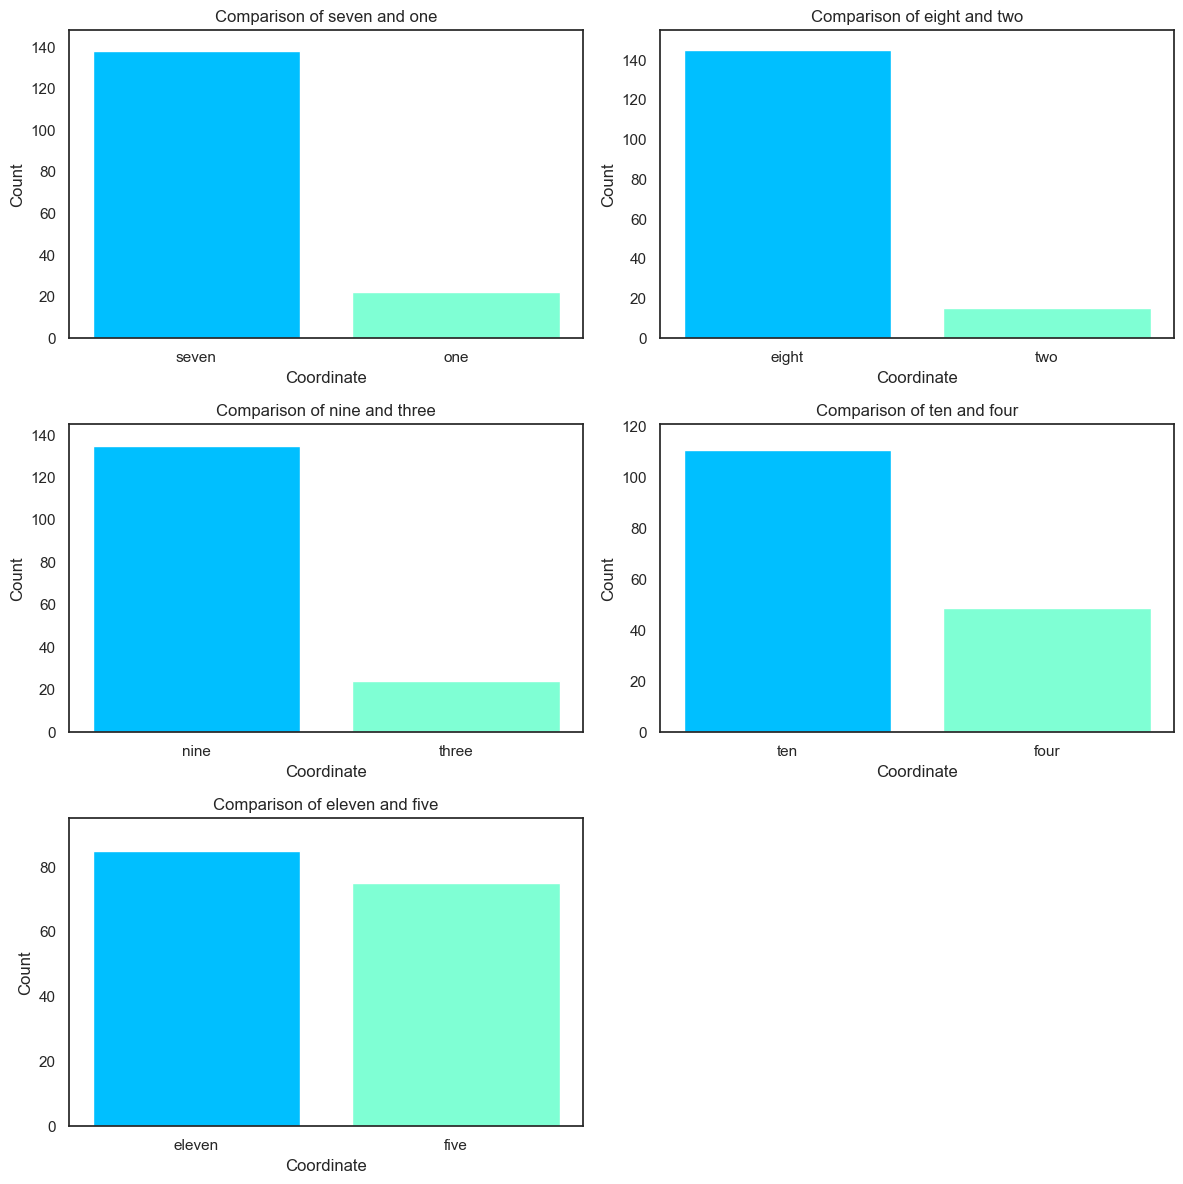

In [144]:
import matplotlib.pyplot as plt

# Create a figure with 5 subplots in a 3x2 grid, but only use 5
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Iterate over the first five pairs
for i, pair in enumerate(pairs[:5]):
    coord1, coord2 = pair
    
    # Select data for the current pair
    data1 = sum_df[sum_df['Coordinate'] == coord1]['Count']
    data2 = sum_df[sum_df['Coordinate'] == coord2]['Count']
    
    # Ensure data is available
    if len(data1) == 0 or len(data2) == 0:
        continue
    
    # Define positions for bars on the x-axis
    x = [1, 2]

    # Define height
    height1 = data1.values[0]
    height2 = data2.values[0]

    # Define labels for the x-axis
    labels = [coord1, coord2]

    # Define colors for the bars
    bar_colors = ['#00BFFF', '#7FFFD4']

    # Create histogram and define titles and axis-limits
    axs[i].bar(x, [height1, height2], tick_label=labels, color=bar_colors)
    axs[i].set_title(f'Comparison of {coord1} and {coord2}')
    axs[i].set_xlabel('Coordinate')
    axs[i].set_ylabel('Count')
    axs[i].set_ylim(0, max(height1, height2) + 10)

# Remove the last unused subplot
fig.delaxes(axs[-1])

# Optimize layout and show plots
plt.tight_layout()
plt.show()


### Sanity Checks
Testing the used data for some possible problems. In the current case, the last example from the loop above is used by taking the data from *df*. To see the event frequency for all participant, include the method *check_balancing_erros* into the loop.

**Show logging output** \
At first, the output from the logging in OpenSesame is shown and can be checked for completeness.

In [145]:
# df is the dataframe for the last participant
check_balancing_errors(df)

Event frequency in the 'USER' column:
USER
SHOW_STIMULUS                        48
START_SEQUENCE                       42
STOP_SEQUENCE                        38
HIDE_STIMULUS                        37
COORDINATES:(-160,277, 160, -277)     4
COORDINATES:(277,-160, -277, 160)     4
STIMULI: (011.PNG, 003.PNG)           4
COORDINATES:(-277,160, 277, -160)     4
COORDINATES:(0,-320, 0, 320)          4
STIMULI: (000.PNG, 006.PNG)           4
COORDINATES:(320,0, -320, 0)          4
COORDINATES:(0,320, 0, -320)          4
COORDINATES:(160,277, -160, -277)     4
COORDINATES:(160,-277, -160, 277)     4
COORDINATES:(277,160, -277, -160)     4
COORDINATES:(-277,-160, 277, 160)     4
COORDINATES:(-320,0, 320, 0)          4
COORDINATES:(-160,-277, 160, 277)     4
STIMULI: (020.PNG, 001.PNG)           2
STIMULI: (004.PNG, 020.PNG)           2
STIMULI: (003.PNG, 000.PNG)           2
STIMULI: (017.PNG, 005.PNG)           2
STIMULI: (021.PNG, 021.PNG)           2
STIMULI: (010.PNG, 013.PNG)          

**Count extracted fixations** \
Inside the loop, the fixations for each participants are counted and printed out here. As visible, beside one run, for every other one 48 fixations were counted for the 48 stimuli pairs.

In [146]:
# Checking how many fixations were counted for every participant
print(fixation_count)

[48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 47, 48, 48]


**Appearence of stimuli pairs** \
The last check shows the distribution of the shown pairs. As visible, one fixation for the pair three/six could not be detected, but overall the pairs are balanced.

In [147]:
# Checking how often every stimuli pair occured
opposite_sums = []
total_sum = 0

opposite_sums.append(sum_df[sum_df['Coordinate'] == 'one']['Count'].values + sum_df[sum_df['Coordinate'] == 'seven']['Count'])
opposite_sums.append(sum_df[sum_df['Coordinate'] == 'two']['Count'].values + sum_df[sum_df['Coordinate'] == 'eight']['Count'])
opposite_sums.append(sum_df[sum_df['Coordinate'] == 'three']['Count'].values + sum_df[sum_df['Coordinate'] == 'nine']['Count'])
opposite_sums.append(sum_df[sum_df['Coordinate'] == 'four']['Count'].values + sum_df[sum_df['Coordinate'] == 'ten']['Count'])
opposite_sums.append(sum_df[sum_df['Coordinate'] == 'five']['Count'].values + sum_df[sum_df['Coordinate'] == 'eleven']['Count'])
opposite_sums.append(sum_df[sum_df['Coordinate'] == 'six']['Count'].values + sum_df[sum_df['Coordinate'] == 'twelve']['Count'])

for i in range(0, 6):
    print(i+1, sum(opposite_sums[i]), sep=': ')
    total_sum = total_sum + sum(opposite_sums[i])

print('Total sum: ', total_sum)
print('Expected sum: ', len(tsv_files)*48)

1: 160.0
2: 160.0
3: 159.0
4: 160.0
5: 160.0
6: 160.0
Total sum:  959.0
Expected sum:  960
